In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
cd ~/.kaggle

/root/.kaggle


In [5]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [6]:
cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [7]:
folderpath = '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata'

In [8]:
import random
import tensorflow as tf
seed_num = 71
random.seed(seed_num)

In [9]:
import numpy as np
import os


# 파라미터로 학습 및 테스트 폴더의 모든 서명 데이터를 읽고
#전체 서명의 길이 중 가장 긴 길이의 값을 반환
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d,tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

# 파라미터로 주어진 폴더에 들어 있는 서명 파일 전체를 읽고,
#n_files * n_max_len * 2 크기의 numpy 배열로 만들어 반환
# 파라미터 n_max_len은 전체 서명 데이터들 중 가장 긴 서며야의 길이를 의미

# 데이터와 함께 반환하는 len_sign 는 각 서명의 실제 길이를 의미

def load_data(folderpath, n_max_len, sig_ids):
  filelist = os.listdir(folderpath)
  n_files = len(filelist)
  d = np.zeros((n_files, n_max_len,2))

  len_sign = np.zeros(n_files)

  for i in sig_ids:
    filepath = f'{folderpath}/{i}.TXT'
    d_tmp, len_sign[i-sig_ids[0]] = load_a_sig(filepath)

    d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp
  return d,len_sign


# 파라미터로 주어진 서명 파일을 읽고, nPoint * 2 크기의 numpy 배열로 만들어 반환

def load_a_sig(filepath):
  f = open(filepath,'rt')
  nPoints = int(f.readline())

  d = np.zeros((nPoints,2))
  for i in range(nPoints):
    line = f.readline()
    toks = line.split(' ')
    d[i,:] = [int(toks[0]), int(toks[1])]
  f.close()
  return d, nPoints

In [10]:
n_train = 800
n_test = 800

n_max_len = get_max_len(f'{folderpath}/Train', f'{folderpath}/Test')

x_train, x_train_len = load_data(f'{folderpath}/Train', n_max_len,range(n_train))

x_test, x_test_len = load_data(f'{folderpath}/Test', n_max_len, range(n_train,1600))

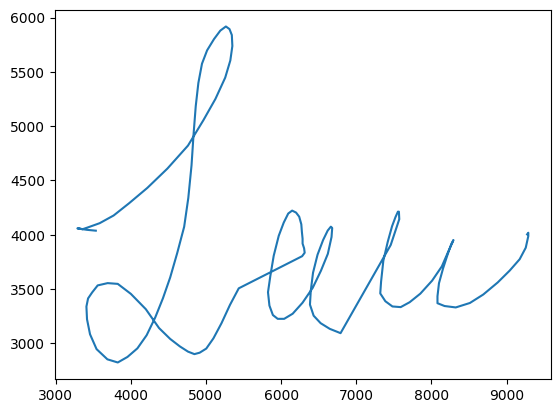

In [11]:
import matplotlib.pyplot as plt
s_id = 10
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0], x_train[s_id, :len_sig,1])

In [12]:
for i in range(x_train.shape[0]):
  len_tmp = int(x_train_len[i])
  h_min = np.min(x_train[i,:len_tmp,0])
  h_max = np.max(x_train[i,:len_tmp,0])
  v_min = np.min(x_train[i,:len_tmp,1])
  v_max = np.max(x_train[i,:len_tmp,1])
  w_h_ratio = (v_max - v_min) / (h_max - h_min)
  x_train[i,:len_tmp,0] = (x_train[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_train[i,:len_tmp,1] = (x_train[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

for i in range(x_test.shape[0]):
  len_tmp = int(x_test_len[i])
  h_min = np.min(x_test[i,:len_tmp,0])
  h_max = np.max(x_test[i,:len_tmp,0])
  v_min = np.min(x_test[i,:len_tmp,1])
  v_max = np.max(x_test[i,:len_tmp,1])

  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  x_test[i,:len_tmp,0] = (x_test[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_test[i,:len_tmp,1] = (x_test[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio


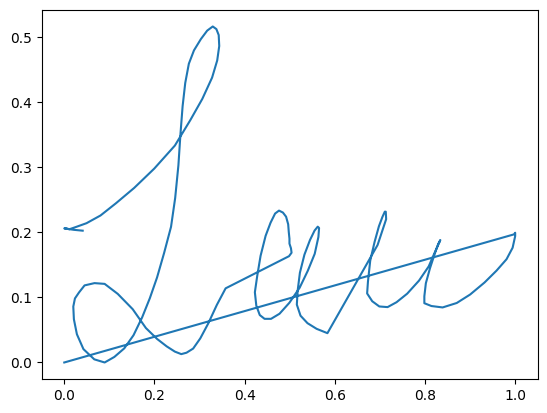

In [13]:
import matplotlib.pyplot as plt
s_id = 10
plt.plot(x_train[s_id,:,0],x_train[s_id,:,1])

In [14]:
import pandas as pd
from tensorflow import keras

y_pd = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/train_info.csv')
y_all = np.array(y_pd['bGenuine'])
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
# y_test = y_all[:n_train]


In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.utils import shuffle
from keras.layers import *
from keras.models import Model
from keras import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler

seed_num = 71
random.seed(seed_num)
tf.random.set_seed(seed_num)

# 데이터 증강을 위한 함수 정의 (예: 시계열 데이터인 경우)
def augment_data(X):
    augmented_X = []
    for x in X:
        noise = np.random.normal(0, 0.05, x.shape)
        augmented_X.append(x + noise)
    return np.array(augmented_X)

# y_train을 원-핫 인코딩
y_train_cat = to_categorical(y_train)

# x_train에 데이터 증강 적용
x_train_augmented = augment_data(x_train)
x_train_combined = np.concatenate((x_train, x_train_augmented))
y_train_combined = np.concatenate((y_train_cat, y_train_cat))  # y_train_cat을 두 배로 늘림

model = Sequential()
model.add(Conv1D(32, kernel_size=9, padding='same', activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(64, kernel_size=7, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=7, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 학습률 스케줄러
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    elif epoch < 200:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = LearningRateScheduler(scheduler)

# 데이터 섞기
x_train_combined, y_train_combined = shuffle(x_train_combined, y_train_combined, random_state=seed_num)

hist = model.fit(x=x_train_combined, y=y_train_combined, epochs=400, validation_split=0.3, batch_size=32, callbacks=[lr_scheduler])


Epoch 1/400
35/35 [==============================] - 15s 58ms/step - loss: 1.1465 - accuracy: 0.5286 - val_loss: 0.7024 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 2/400
35/35 [==============================] - 1s 29ms/step - loss: 0.9811 - accuracy: 0.5804 - val_loss: 0.6906 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 3/400
35/35 [==============================] - 1s 27ms/step - loss: 0.9546 - accuracy: 0.5545 - val_loss: 0.6951 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 4/400
35/35 [==============================] - 1s 31ms/step - loss: 0.8242 - accuracy: 0.5973 - val_loss: 0.6930 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 5/400
35/35 [==============================] - 1s 22ms/step - loss: 0.8170 - accuracy: 0.5929 - val_loss: 0.6939 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 6/400
35/35 [==============================] - 1s 22ms/step - loss: 0.7243 - accuracy: 0.6223 - val_loss: 0.8293 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 7/400
35/35 [==============================] - 1s 24ms/step - l

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def drawHistory(hist) :

  # hist.history를 데이터프레임으로 변환
  history_df = pd.DataFrame(hist.history)

  # 데이터프레임을 표로 출력
  print(history_df)

  # 데이터프레임을 시각화 (옵션)
  plt.figure(figsize=(12, 6))

  # 훈련 손실과 검증 손실 그래프
  plt.subplot(1, 2, 1)
  plt.plot(history_df['loss'], label='Training Loss')
  plt.plot(history_df['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # 훈련 정확도와 검증 정확도 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history_df['accuracy'], label='Training Accuracy')
  plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plt.show()



In [ ]:
drawHistory(hist)

In [ ]:
o = model.predict(x_test)

In [ ]:
o = np.argmax(o,1)

In [ ]:
df = pd.DataFrame(o)
df.columns = ['bGenuine']
df.index = range(800, 800+len(df))
df.index.name = 'num'
print(df)
df.to_csv('test_predict.csv')

In [ ]:
!kaggle competitions submit -c pknu-deep-learning-2024 -f test_predict.csv -m "Message"

In [ ]:
cp finalProject.ipynb ../colab_repo_for_deep_learning/finalProject.ipynb

In [ ]:
cd ../colab_repo_for_deep_learning

In [ ]:
!git config --global user.email "wkdghdwns199@naver.com"

In [ ]:
!git config --global user.name "Jang Hong Joon"

In [ ]:
!git add *

In [ ]:
!git commit -m "commit"

In [ ]:
!git push origin main

In [ ]:
cd /content/gdrive/MyDrive/Colab\ Notebooks